**Predicting Bike-share Demand Pattern**

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Reading the bike-share data set:

In [23]:
#dataset is available in dataset folder#
data_path = '/content/hour.csv'

rides = pd.read_csv(data_path)


In [24]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### **Dummy Variables**

Instead of the categorical data, we define new dummy variables using pd.get_dummies() method:

In [25]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
  dummies = pd.get_dummies(rides[each], prefix = each, drop_first = False)
  rides = pd.concat([rides, dummies], axis = 1)
#rides.head()

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### **Scaling Continuous Variables:**

To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

In [ ]:
quant_features = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

scaling_factors = {}

for each in quant_features:
  mean, std = data[each].mean(), data[each].std()
  scaling_factors[each] = [mean, std]
  data.loc[:,each] = (data[each] - mean)/std

### **Splitting Data into Train, Validation, and Test Sets:**

We'll save the data for the last approximately 30 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [ ]:
test_data = data[-30*24:]

train_data = data[:-30*24]

target_fields = ['casual', 'registered', 'cnt']

features, targets = data.drop(target_fields, axis = 1), data[target_fields]

test_features , test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

train_features, train_targets = features[:-60*24], targets[:-60*24]

val_features, val_targets = features[-60*24:], targets[-60*24:]

### **Neural Network:**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(NeuralNet, self).__init__()
    self.Layer1 = nn.Linear(in_features= input_size, out_features= hidden_size)
    self.Layer2 = nn.Linear(in_features= hidden_size, out_features= 1)

  def forward(self, X):
    X = self.Layer1(X)
    X = F.relu(X)
    X = self.Layer2(X)
    output = X
    return output


In [ ]:
# features: 2D array, each row is one data record, each column is a feature
# targets: 1D array of target values

n_records = features.shape[0]
n_features = features.shape[1]
model = NeuralNet( n_features, 32)
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)


### **Training Loop:**

epoch: 0, training loss:0.8524696230888367
epoch: 200, training loss:0.5630555152893066
epoch: 400, training loss:0.5014197826385498
epoch: 600, training loss:0.367323100566864
epoch: 800, training loss:0.35013219714164734
epoch: 1000, training loss:0.26215678453445435
epoch: 1200, training loss:0.38480067253112793
epoch: 1400, training loss:0.17457231879234314
epoch: 1600, training loss:0.4089107811450958
epoch: 1800, training loss:0.25884193181991577
epoch: 2000, training loss:0.20642587542533875
epoch: 2200, training loss:0.24161340296268463
epoch: 2400, training loss:0.24540957808494568
epoch: 2600, training loss:0.2472892701625824
epoch: 2800, training loss:0.18770810961723328
epoch: 3000, training loss:0.2668391168117523
epoch: 3200, training loss:0.18047556281089783
epoch: 3400, training loss:0.19178573787212372
epoch: 3600, training loss:0.22104601562023163
epoch: 3800, training loss:0.14821410179138184
epoch: 4000, training loss:0.09953097254037857
epoch: 4200, training loss:0

Text(0.5, 0, 'epoch')

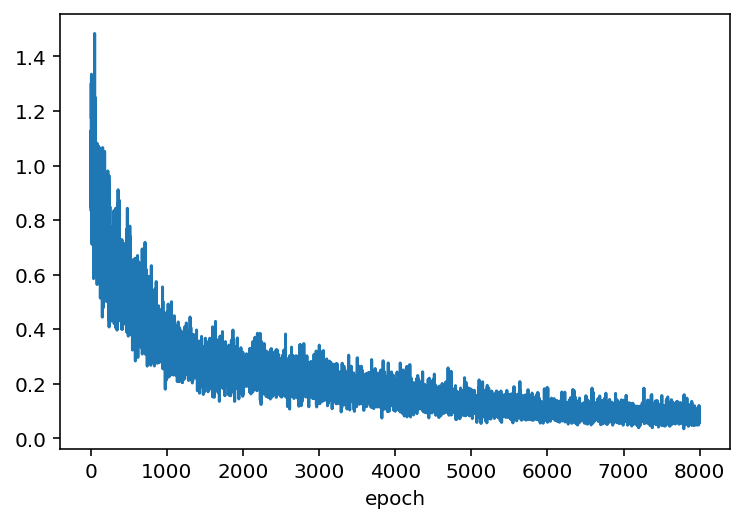

In [ ]:
epochs = 8000
Loss = []
for epoch in range(epochs):

  batch = np.random.choice(train_features.index, size=128)
  X, y = train_features.loc[batch].values, train_targets.loc[batch]['cnt'].values
  X_train = torch.from_numpy(X.astype(np.float32))
  y_train = torch.from_numpy(y.astype(np.float32))

  y_train = y_train.view(y_train.shape[0],1)



  y_predicted = model(X_train)
  loss = criterion(y_train, y_predicted)
  Loss.append(loss.item())
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

  if epoch % 200 == 0:
    print("epoch: {}, training loss:{}".format(epoch, loss.item()))


# Plot
plt.plot(range(epochs),Loss, label = 'Training Loss')
plt.xlabel('epoch')

### **Testing performance of the trained neural network on the test dataset:**

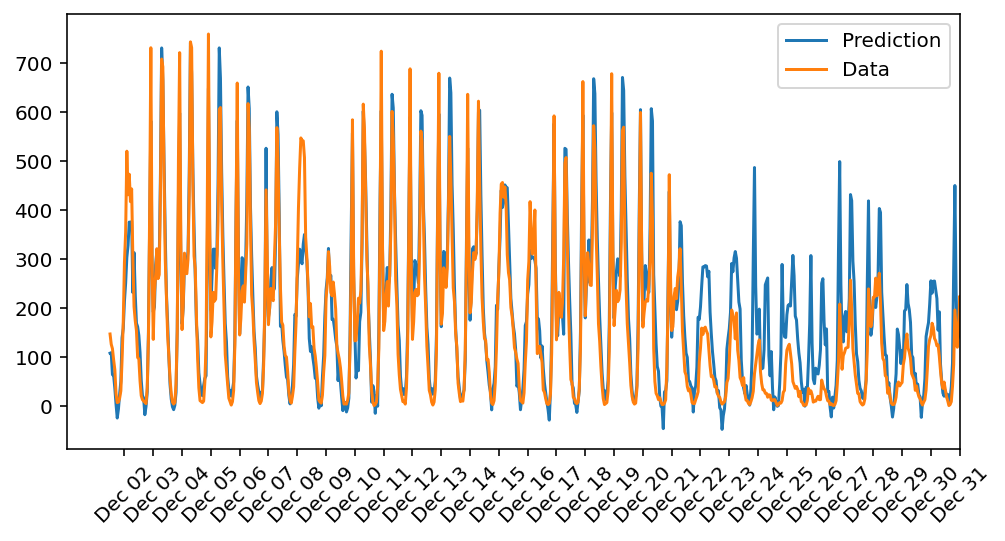

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaling_factors['cnt']
X_test = torch.from_numpy(test_features.values.astype(np.float32))
predictions = model(X_test).detach().numpy().T*std + mean

ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)